# **TextClassification**

Text classification is a supervised learning task. In supervised learning, the algorithm is trained on a labeled dataset, meaning each input (in this case, a text document) is associated with a corresponding output label (the category or class it belongs to).

## **Importing Libraries**

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from wordcloud import WordCloud
from sklearn.linear_model import LogisticRegression
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from imblearn.over_sampling import SMOTE
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Reading the Dataset

In [73]:
df=pd.read_csv("/content/Emotions_training.csv")
df.head(3)
df.shape

(16000, 2)

In [74]:
word_count = df['text'].str.split().apply(len).sum()
print("Total number of words in the column:", word_count)

Total number of words in the column: 306661


In [143]:
# Ensure reproducibility by setting the random seed
np.random.seed(42)

## Check whether the dataset is balanced or not

In [75]:
# Define emotion labels
emotion_labels = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

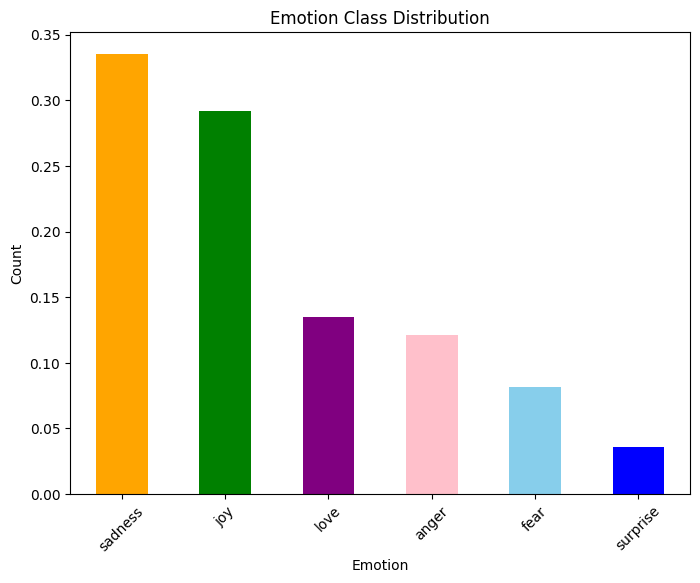

The dataset is imbalanced.


In [76]:
# Count occurrences of each class
class_counts = df['label'].value_counts()
# Calculate class proportions
total_samples = len(df)
class_proportions = class_counts / total_samples
colors=['orange','green','purple','pink','skyblue','blue']
# Plot class distribution
plt.figure(figsize=(8, 6))
class_proportions.plot(kind='bar', color=colors)
plt.title('Emotion Class Distribution')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(range(len(emotion_labels)), [emotion_labels[i] for i in range(len(emotion_labels))], rotation=45)
plt.show()
# Check for class imbalance
is_imbalanced = class_proportions.std() > 0.05  # Adjust threshold as needed
if is_imbalanced:
    print("The dataset is imbalanced.")
else:
    print("The dataset is balanced.")

# **TF**-**IDF**
*   We preprocess the text data using TF-IDF vectorization to convert it into numerical features (X_tfidf).

*   We initialize the SMOTE object and apply it to the TF-IDF transformed features along with the class labels (data['label']) to generate synthetic samples.



# **SMOTE**
*  SMOTE, which stands for Synthetic Minority Over-sampling Technique, is a powerful technique used in the field of imbalanced classification to address the issue of class imbalance. It is primarily used to balance class distribution by oversampling the minority class and can also be adapted for undersampling the majority class.

In [77]:
# Step 1: Preprocess text data and convert it into numerical features
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Adjust max_features as needed
X_text = df['text']
X_tfidf = tfidf_vectorizer.fit_transform(X_text)
# Step 2: Initialize SMOTE
smote = SMOTE(random_state=42)
# Step 3: Apply SMOTE to generate synthetic samples only for minority classes
X_resampled, y_resampled = smote.fit_resample(X_tfidf, df['label'])

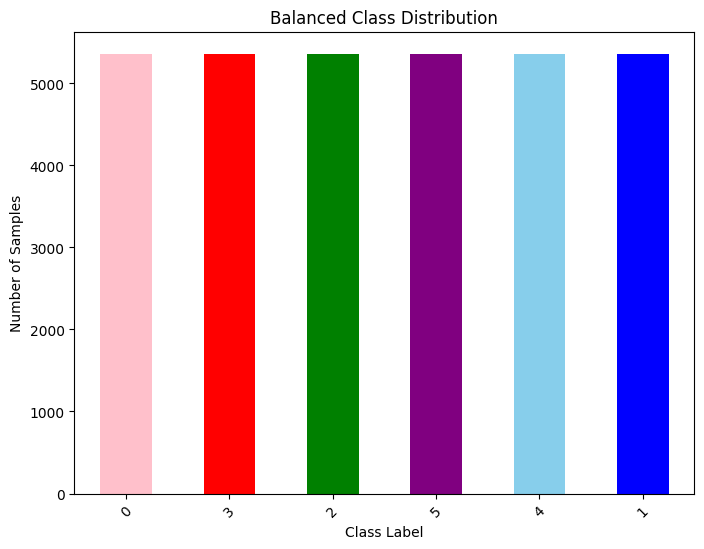

In [78]:
# Count occurrences of each class in the resampled dataset
class_counts = pd.Series(y_resampled).value_counts()
colors = ['pink', 'red', 'green', 'purple','skyblue','blue']
# Plot class distribution
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color=colors)
plt.title('Balanced Class Distribution')
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()

Now, the class is balanced

# **Data Preprocessing**







Data preprocessing is a crucial step in the data analysis and machine learning pipeline as it can significantly impact the performance and reliability of downstream analyses and models. Properly preprocessing data can help improve model accuracy, reduce overfitting, and ensure that the resulting insights are accurate and reliable.
*   Lower Case
*   Remove Links
*   Remove next lines(\n)
*   Words containing numbers
*   Extra Spaces
*   Special Characters
*   Removal of stop words
*   Stemming
*   Lemmatization



## **1.   Lower Case**



In [79]:
#Lower Case
df['text']=df['text'].str.lower()

## **2**. **Remove Links**

In [80]:
#Remove Links
def remove_links(text):
    p=r'https?://\S+'
    return re.sub(p,'',text)
df['text']=df['text'].apply(remove_links)

## **3. Remove next lines(\n)**

In [81]:
#removing next lines
def remove_next_lines(text):
    return text.replace('/n','')
df['text']=df['text'].apply(remove_next_lines)

## **4. Remove Words containing numbers**

In [82]:
#removing words with numbers
def remove_words_with_numbers(text):
  return ' '.join(word for word in text.split() if not any(c.isdigit() for c in word))
df['text'] = df['text'].apply(remove_words_with_numbers)

## **5. Remove Extra Spaces**

In [83]:
#remove extraspaces
def remove_extraspaces(text):
    p=r'\s+'
    return re.sub(p,'',text)
df['text']=df['text'].apply(remove_extraspaces)

## **6. Remove Special Characters**

In [84]:
#removing special characters
def remove_special_char(text):
    p=r'^\w\s+'
    return re.sub(p,'',text)
df['text']=df['text'].apply(remove_special_char)

## **7. Removal of stop words**

In [85]:
#removing stop words
stop_words = stopwords.words('english')
def remove_stopwords(text):
  words = nltk.word_tokenize(text)
  filtered_words = [word for word in words if word.lower() not in stop_words]
  return ' '.join(filtered_words)
df['text'] = df['text'].apply(remove_stopwords)

## **8. Stemming**

In [86]:
#stemming
stemmer = PorterStemmer()
def stem_words(text):
    words = nltk.word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)
df['text'] = df['text'].apply(stem_words)

## **9. Lemmatization**

In [87]:
#lemmatization
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    words = nltk.word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)
df['text'] = df['text'].apply(lemmatize_words)
df.head(5)

,text,label
0,ididntfeelhumili,0
1,icangofromfeelingsohopelesstosodamnedhopefulju...,0
2,imgrabbingaminutetopostifeelgreedywrong,3
3,iameverfeelingnostalgicaboutthefireplaceiwillk...,2
4,iamfeelinggrouchi,3


After Preprocessing the number of words in the text column is reduced to 16k

In [88]:
word_count = df['text'].str.split().apply(len).sum()
print("Total number of words in the column:", word_count)
df.shape

Total number of words in the column: 16000


(16000, 2)

## Dividing the dataset in to
*   Training-70%
*   Testing-20%
*   Validation-10%



In [124]:
# Split the resampled data into training and temporary sets (80% training and 20% temporary)
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
# Further split the temporary set into training and validation sets (70% training and 10% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.125, random_state=42)
# Print the shapes of the resulting sets
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (22519, 1000)
Validation set shape: (3218, 1000)
Testing set shape: (6435, 1000)


# **Classification** **Models**





on Balanced data

A classification model is used to predict categorical labels or classes based on input features. It is a fundamental tool in supervised learning, where the model learns patterns from labeled data to make predictions on new, unseen instances.

# **SVM** (Support Vector Machine)

Support Vector Machines (SVMs) are a class of supervised learning models that excel in both linear and nonlinear classification tasks. The fundamental principle behind SVMs is to find the optimal hyperplane that best separates different classes in the feature space.

In [125]:
# Initialize SVM classifier
svm_classifier = SVC(kernel='linear', random_state=42)  # You can choose different kernels and parameters
# Train the SVM classifier on the training data
svm_classifier.fit(X_train, y_train)
# Make predictions on the validation set
y_val_pred_svm = svm_classifier.predict(X_val)
# Make predictions on the test set
y_test_pred_svm = svm_classifier.predict(X_test)
# Evaluate the performance on the test set
print("\nTest Set Performance:")
print(classification_report(y_test, y_test_pred_svm))


Test Set Performance:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1087
           1       0.87      0.86      0.86      1078
           2       0.92      0.97      0.94      1059
           3       0.89      0.91      0.90      1057
           4       0.93      0.85      0.89      1081
           5       0.92      0.98      0.95      1073

    accuracy                           0.91      6435
   macro avg       0.91      0.91      0.91      6435
weighted avg       0.91      0.91      0.91      6435



In [126]:
# Make predictions on the training set
y_train_pred_svm = svm_classifier.predict(X_train)
# Evaluate the performance on the training set
print("Training Set Performance:")
print(classification_report(y_train, y_train_pred_svm))

Training Set Performance:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      3736
           1       0.89      0.88      0.88      3770
           2       0.92      0.97      0.95      3773
           3       0.93      0.91      0.92      3773
           4       0.94      0.88      0.91      3748
           5       0.93      0.99      0.96      3719

    accuracy                           0.92     22519
   macro avg       0.92      0.92      0.92     22519
weighted avg       0.92      0.92      0.92     22519



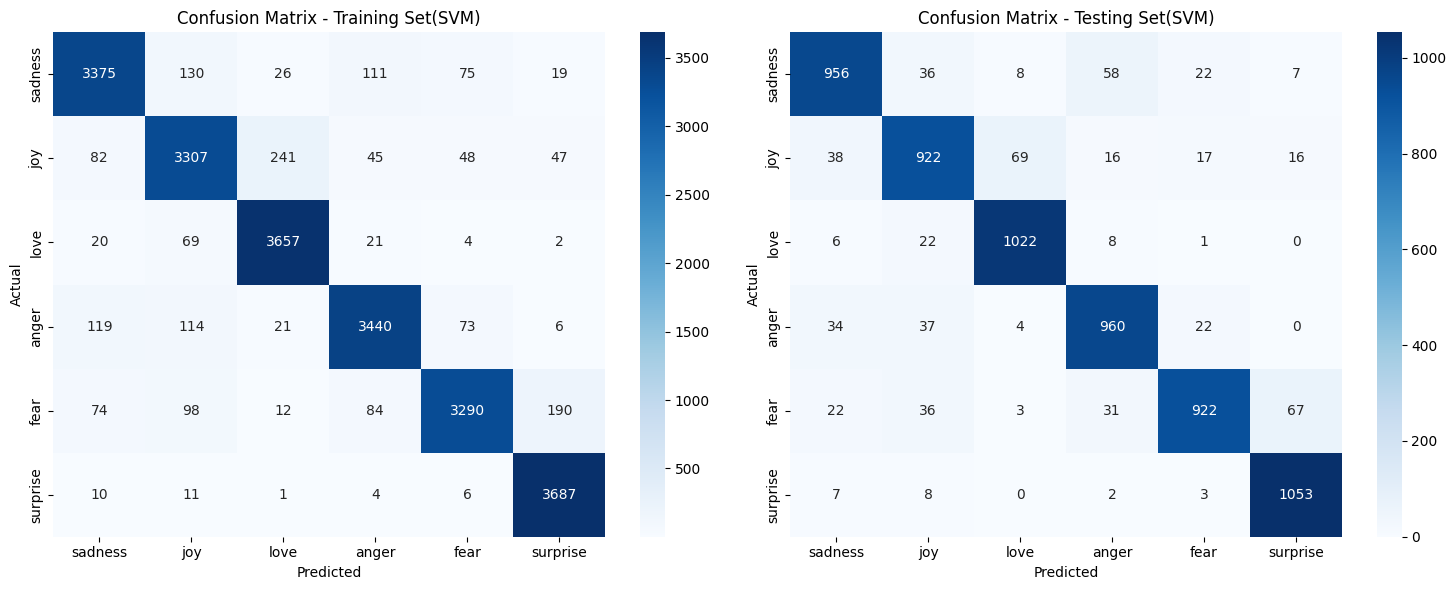

In [127]:
# Define a function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title, ax):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', ax=ax, xticklabels=[emotion_labels[i] for i in range(len(emotion_labels))], yticklabels=[emotion_labels[i] for i in range(len(emotion_labels))])
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
# Initialize subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
# Plot confusion matrix for training set
plot_confusion_matrix(y_train, y_train_pred_svm, title='Confusion Matrix - Training Set(SVM)', ax=axes[0])
# Plot confusion matrix for testing set
plot_confusion_matrix(y_test, y_test_pred_svm, title='Confusion Matrix - Testing Set(SVM)', ax=axes[1])
# Adjust layout
plt.tight_layout()
# Show plots
plt.show()

In [128]:
# Calculate accuracy for training set
accuracy_train_svm = accuracy_score(y_train, y_train_pred_svm)
print("Accuracy on Training Set (SVM):", accuracy_train_svm)
# Calculate accuracy for testing set
accuracy_test_svm = accuracy_score(y_test, y_test_pred_svm)
print("Accuracy on Testing Set (SVM):", accuracy_test_svm)

Accuracy on Training Set (SVM): 0.921710555530885
Accuracy on Testing Set (SVM): 0.9067599067599068


# **Random Forest**


Random Forest is an ensemble learning technique that builds multiple decision trees during training and outputs the mode of the classes (for classification) or the mean prediction (for regression) of the individual trees.

In [129]:
classifier_rf = RandomForestClassifier(n_estimators=50, max_depth=50, min_samples_split=5, random_state=42)  # Adjust hyperparameters
classifier_rf.fit(X_train, y_train)
# Evaluate the classifier's performance on the testing set
y_test_pred_rf = classifier_rf.predict(X_test)
print("Testing Set Classification Report:")
print(classification_report(y_test, y_test_pred_rf))

Testing Set Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.77      0.70      1087
           1       0.72      0.61      0.66      1078
           2       0.91      0.96      0.94      1059
           3       0.93      0.87      0.90      1057
           4       0.95      0.86      0.90      1081
           5       0.94      0.99      0.96      1073

    accuracy                           0.84      6435
   macro avg       0.85      0.84      0.84      6435
weighted avg       0.85      0.84      0.84      6435



In [130]:
# Print classification report for testing set
y_train_pred_rf=classifier_rf.predict(X_train)
print("Testing Set Classification Report:")
print(classification_report(y_train, y_train_pred_rf))

Testing Set Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.91      0.81      3736
           1       0.84      0.80      0.82      3770
           2       0.99      0.97      0.98      3773
           3       0.99      0.90      0.94      3773
           4       0.99      0.91      0.95      3748
           5       1.00      0.99      0.99      3719

    accuracy                           0.91     22519
   macro avg       0.92      0.91      0.92     22519
weighted avg       0.92      0.91      0.92     22519



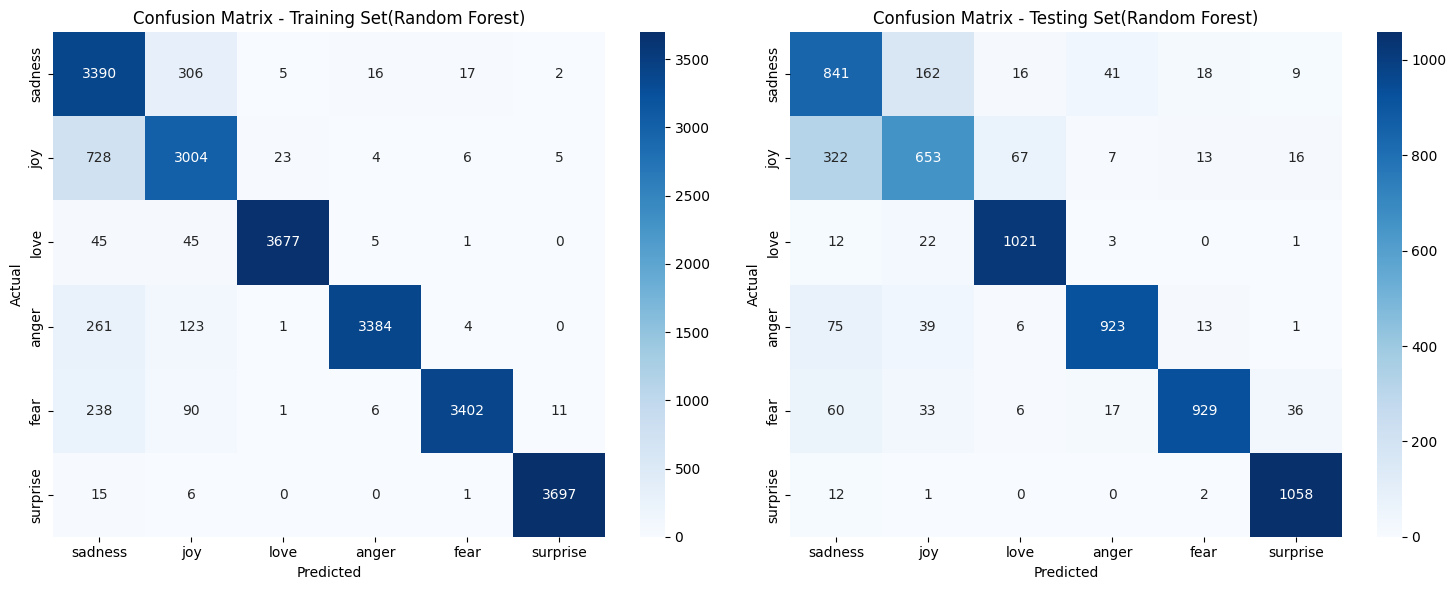

In [131]:
# Initialize subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
# Plot confusion matrix for training set
plot_confusion_matrix(y_train, y_train_pred_rf, title='Confusion Matrix - Training Set(Random Forest)', ax=axes[0])
# Plot confusion matrix for testing set
plot_confusion_matrix(y_test, y_test_pred_rf, title='Confusion Matrix - Testing Set(Random Forest)', ax=axes[1])
# Adjust layout
plt.tight_layout()
# Show plots
plt.show()

In [132]:
# Calculate accuracy for training set
accuracy_train_rf = accuracy_score(y_train, y_train_pred_rf)
print("Accuracy on Training Set:", accuracy_train_rf)
# Calculate accuracy for testing set
accuracy_test_rf = accuracy_score(y_test, y_test_pred_rf)
print("Accuracy on Testing Set:", accuracy_test_rf)

Accuracy on Training Set: 0.9127403525911453
Accuracy on Testing Set: 0.8430458430458431


# **Naive Bayes**

 Naive Bayes is a probabilistic classifier that applies Bayes' theorem with strong independence assumptions between the features. It is called "naive" because it assumes that the presence of a particular feature in a class is independent of the presence of other features, which may not always hold true in real-world data.

In [133]:
# Convert sparse matrix to dense numpy array
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()
# Define the classifier (Naive Bayes)
classifier_nb = GaussianNB()
# Train the classifier on the balanced training data
classifier_nb.fit(X_train_dense, y_train)
# Make predictions on the balanced training data
y_train_pred_nb = classifier_nb.predict(X_train_dense)
# Make predictions on the balanced testing data
y_test_pred_nb = classifier_nb.predict(X_test_dense)

In [134]:
# Print classification report for training set
print("Training Set Classification Report:")
print(classification_report(y_train, y_train_pred_nb))

Training Set Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.65      0.77      3736
           1       0.96      0.59      0.73      3770
           2       0.75      0.94      0.83      3773
           3       0.89      0.76      0.82      3773
           4       0.83      0.74      0.78      3748
           5       0.58      1.00      0.73      3719

    accuracy                           0.78     22519
   macro avg       0.83      0.78      0.78     22519
weighted avg       0.83      0.78      0.78     22519



In [135]:
# Print classification report for testing set
print("Testing Set Classification Report:")
print(classification_report(y_test, y_test_pred_nb))

Testing Set Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.63      0.75      1087
           1       0.94      0.60      0.74      1078
           2       0.74      0.94      0.83      1059
           3       0.85      0.75      0.80      1057
           4       0.82      0.69      0.75      1081
           5       0.57      0.99      0.73      1073

    accuracy                           0.76      6435
   macro avg       0.81      0.77      0.76      6435
weighted avg       0.81      0.76      0.76      6435



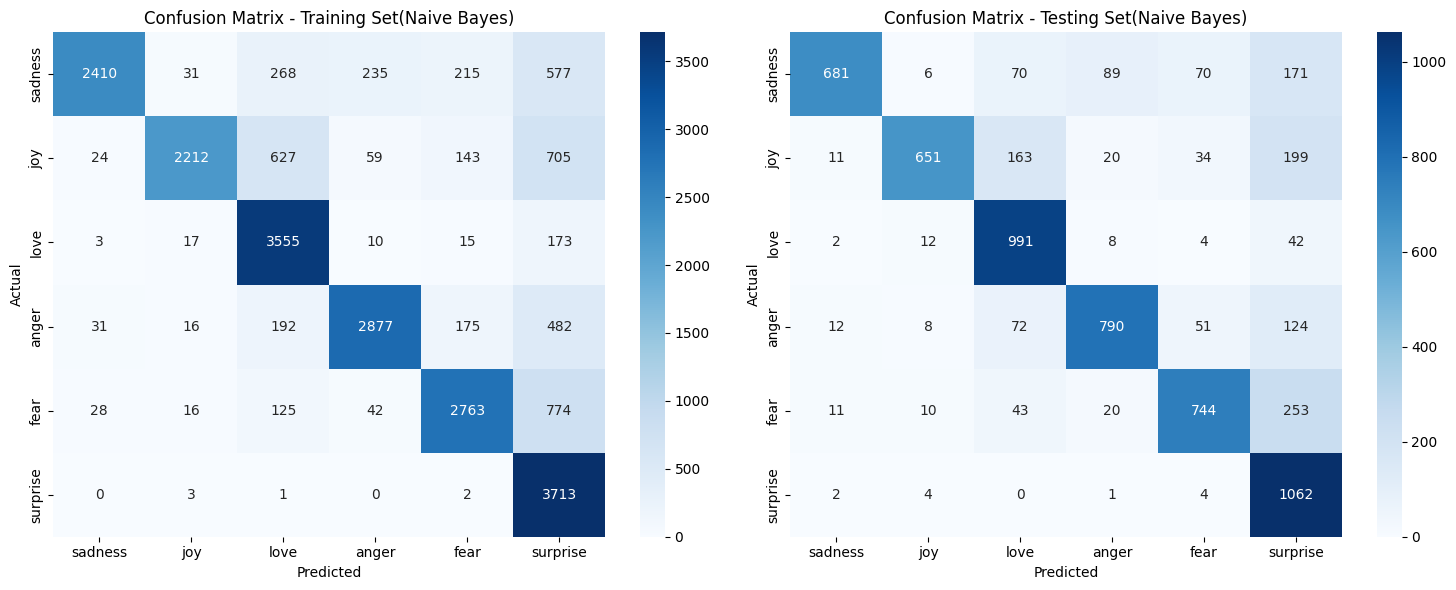

In [136]:
# Initialize subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
# Plot confusion matrix for training set
plot_confusion_matrix(y_train, y_train_pred_nb, title='Confusion Matrix - Training Set(Naive Bayes)', ax=axes[0])
# Plot confusion matrix for testing set
plot_confusion_matrix(y_test, y_test_pred_nb, title='Confusion Matrix - Testing Set(Naive Bayes)', ax=axes[1])
# Adjust layout
plt.tight_layout()
# Show plots
plt.show()

In [137]:
# Calculate accuracy for training set
accuracy_train_nb = accuracy_score(y_train, y_train_pred_nb)
print("Accuracy on Training Set (Naive Bayes):", accuracy_train_nb)
# Calculate accuracy for testing set
accuracy_test_nb = accuracy_score(y_test, y_test_pred_nb)
print("Accuracy on Testing Set (Naive Bayes):", accuracy_test_nb)

Accuracy on Training Set (Naive Bayes): 0.7784537501665261
Accuracy on Testing Set (Naive Bayes): 0.7644133644133644


# **XG Boost**

XGBoost (Extreme Gradient Boosting) is an ensemble learning algorithm known for its exceptional performance and versatility in a wide range of machine learning tasks. It belongs to the family of gradient boosting algorithms. Its ability to handle large datasets, control model complexity, and provide valuable insights makes it a go-to choice for many data scientists and machine learning practitioners.

In [138]:
# Step 1: Initialize the XGBoost classifier with adjusted parameters
classifier_xgb = xgb.XGBClassifier(max_depth=6, min_child_weight=1, random_state=42)
# Step 2: Train the XGBoost classifier on the training data
classifier_xgb.fit(X_train, y_train)
# Step 3: Make predictions on the test data
y_test_pred_xgb = classifier_xgb.predict(X_test)
# Step 4: Evaluate the classifier's performance on the testing set
print("Testing Set Classification Report - XGBoost:")
print(classification_report(y_test, y_test_pred_xgb))

Testing Set Classification Report - XGBoost:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90      1087
           1       0.81      0.90      0.85      1078
           2       0.94      0.96      0.95      1059
           3       0.93      0.90      0.91      1057
           4       0.94      0.88      0.91      1081
           5       0.96      0.98      0.97      1073

    accuracy                           0.91      6435
   macro avg       0.92      0.92      0.92      6435
weighted avg       0.92      0.91      0.92      6435



In [139]:
y_train_pred_xgb=classifier_xgb.predict(X_train)
print("Training Set Classification Report - XGBoost:")
print(classification_report(y_train, y_train_pred_xgb))

Training Set Classification Report - XGBoost:
              precision    recall  f1-score   support

           0       0.97      0.92      0.95      3736
           1       0.84      0.97      0.90      3770
           2       0.98      0.98      0.98      3773
           3       0.98      0.92      0.95      3773
           4       0.98      0.93      0.96      3748
           5       0.99      0.99      0.99      3719

    accuracy                           0.95     22519
   macro avg       0.96      0.95      0.95     22519
weighted avg       0.96      0.95      0.95     22519



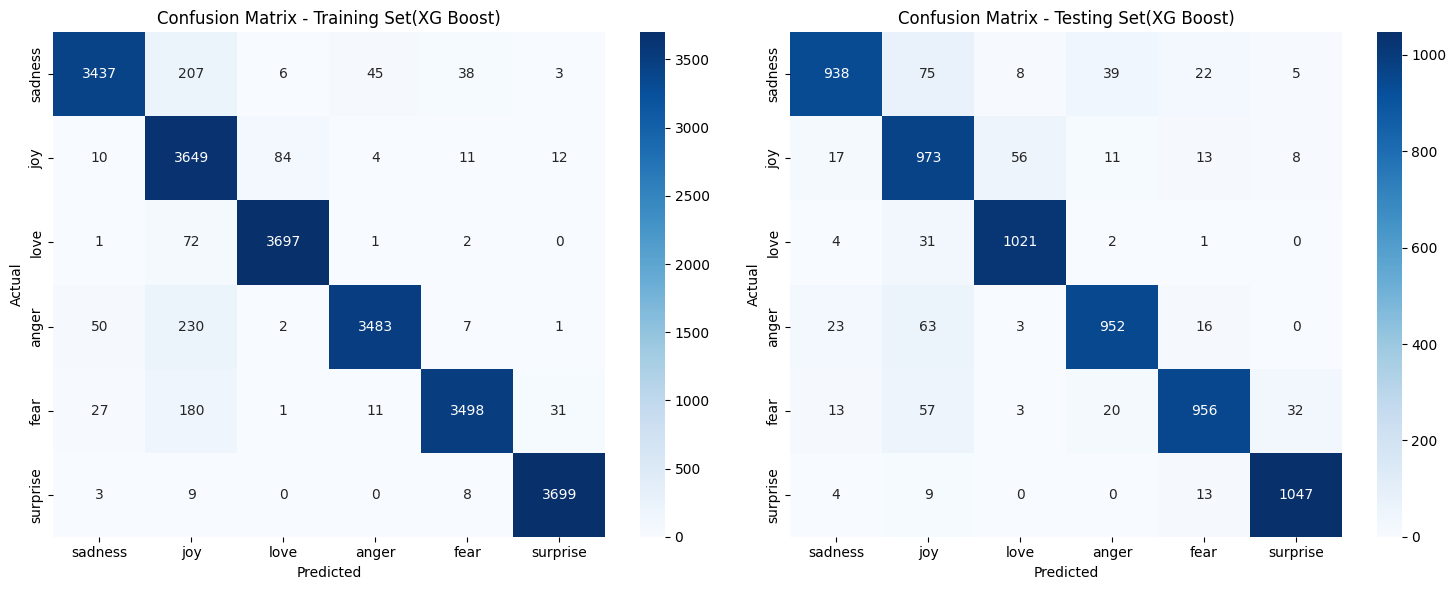

In [140]:
# Initialize subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
# Plot confusion matrix for training set
plot_confusion_matrix(y_train, y_train_pred_xgb, title='Confusion Matrix - Training Set(XG Boost)', ax=axes[0])
# Plot confusion matrix for testing set
plot_confusion_matrix(y_test, y_test_pred_xgb, title='Confusion Matrix - Testing Set(XG Boost)', ax=axes[1])
# Adjust layout
plt.tight_layout()
# Show plots
plt.show()

In [141]:
# Calculate accuracy for training set
accuracy_train_xgb = accuracy_score(y_train, y_train_pred_xgb)
print("Accuracy on Training Set (XG Boost):", accuracy_train_xgb)
# Calculate accuracy for testing set
accuracy_test_xgb = accuracy_score(y_test, y_test_pred_xgb)
print("Accuracy on Testing Set (XG Boost):", accuracy_test_xgb)

Accuracy on Training Set (XG Boost): 0.9531062658199743
Accuracy on Testing Set (XG Boost): 0.9148407148407148


# **Hyperparameter Tuning for Naive Bayes Classifier using GridSearchCV**

In [158]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Define the Naive Bayes classifier
classifier = GaussianNB()

# Define the hyperparameters to tune
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5],
    'priors': [None, [0.2, 0.3, 0.5], [0.1, 0.9, 0.0]]
}

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_dense, y_train)
# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)
best_classifier = grid_search.best_estimator_
y_train_pred_best = best_classifier.predict(X_train_dense)
accuracy_train_best = accuracy_score(y_train, y_train_pred_best)
print("Accuracy on Training Set with Best Hyperparameters (Naive Bayes):", accuracy_train_best)
# Print the accuracy with the best hyperparameters on the testing set
y_test_pred_best = best_classifier.predict(X_test_dense)
accuracy_test_best = accuracy_score(y_test, y_test_pred_best)
print("Accuracy on Testing Set with Best Hyperparameters (Naive Bayes):", accuracy_test_best)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
50 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py", line 267, in fit
    return self._partial_fit(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py", line 454, in _partial_fit
    raise ValueError("Number of priors must match number of classes.")
ValueError: Number of prio

Best hyperparameters: {'priors': None, 'var_smoothing': 1e-05}
Accuracy on Training Set with Best Hyperparameters (Naive Bayes): 0.8327634442026733
Accuracy on Testing Set with Best Hyperparameters (Naive Bayes): 0.8144522144522145


# **Conclusion**

Balanced data

In [163]:
bal_data=pd.read_csv("/content/Balanced_data_accuracy.csv")
bal_data

,Models,Training Accuracy,Testing Accuracy
0,SVM,0.92,0.90
1,Random Forest,0.91,0.84
2,Naive Bayes,0.77,0.76
3,XG Boost,0.95,0.91


XG Boost and SVM performs well on both Training and Testing Accuracy.
 Random Forest offers decent performance but may require further tuning to mitigate overfitting. Naive Bayes, while simple, lags behind in terms of accuracy compared to the other models.